In [ ]:
%cd ../
%pip install -e .
%cd tutorials

# P3P (Perspective-3-Point) in torch : A Step-by-step tutorial with POSEIDON 

## Introduction
Welcome to this interactive Jupyter Notebook!

Pose estimation from minimal geometric constraints plays a central role in 3D computer vision. Among these, the **Perspective-Three-Point** (P3P) problem is a classic: given three 2D-3D point correspondences, estimate the camera's pose. Kneip's method provides a practical and reliable closed-form solution, making it a common choice in pose estimation tasks.

- **Meet `POSEIDON`**, a fast, differentiable PyTorch library implementing Kneip’s P3P algorithm — ideal for real-time, gradient-based learning.

- Built on top of `autoroot`, it leverages differentiable polynomial solvers to bring exact geometry into your training loop.

- Seamless autograd integration means you can embed POSEIDON directly into your loss function — perfect for tasks like training a YOLO model that learns to predict 3D positions, minimizing reprojection or track alignment errors.

Let’s take a look at how POSEIDON combines geometric precision with practical integration into modern pipelines.


In [ ]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import sys  # noqa: avoid having this import removed by pycln

    # install dev version for dev doc, or release version for release doc
    !{sys.executable} -m pip install -U pip
    !{sys.executable} -m pip install git+https://github.com/Pruneeuh/POSEIDON@main#egg=decomon
    # install desired backend (by default torch)
    !{sys.executable} -m pip install "torch"

    # extra librabry used in this notebook
    !{sys.executable} -m pip install "numpy"
    !{sys.executable} -m pip install "cmath"
    !{sys.executable} -m pip install "matplotlib"

Summarizing Kneip PEP Method for a Direct Computation of Absolute Camera Position and Orientation

#### 1. Compute a transformation matrix (T) and the feature vector f3_T in features vectors frame  
$ \space\space\space\space \vec{f_i\_T} = T. \vec{fi} $
#### 2. Compute a transformation matrix (N) and the world point P3_N in the world-point frame  
$ \space\space\space\space P_i\_N = N . (P_i - P_1) $
#### 3. Extract p1 and p2 from P3_N  
$ \space\space\space\space P_3\_N = \begin{pmatrix} p_1 \\ p_2 \\ 0 \end{pmatrix} $
#### 4. Compute d12 and b  
$ \space\space\space\space b = cot \beta = \pm \sqrt{ \frac{1}{1 - cos(\beta)^2} -1 } = \pm \sqrt{ \frac{1}{1 - (\vec{f1}.\vec{f2})^2} -1 }$
#### 5. Compute phi1 and phi2  
$ \space\space\space\space \phi_1 = \frac{(f_3\_T)_x}{(f_3\_T)_z} \space  and \space \phi_2 = \frac{(f_3\_T)_y}{(f_3\_T)_z} $
#### 6. Compute the factors a4,a3,a2,a1 and a0 of polynomial  
$ \space\space\space\space a4 cos^4\theta+a3 cos^3\theta+a2 cos^2\theta + a1 cos\theta +a0 = 0 $
#### 7. Find the real roots of the polynomial (values for cos_teta)  
Using the library [autoroot](https://github.com/Pruneeuh/autoroot) : 
#### 8. For each solutions find the values for cot_alpha  
$ \space\space\space\space cot\alpha = \frac{\frac{\phi_1}{\phi_2}.p1 + cos\theta.p2 - d_{12}.b}{\frac{\phi_1}{\phi_2}.p2 - p1 +d_{12}} $
#### 9. Compute all necessary trigonometric forms of alpha and teta using trigonometric relationships and the restricted parameter domains  
$ \space\space\space\space cos\theta = \real{(root)} \\ 
 \space\space\space\space sin\alpha = \sqrt{ \frac{1}{cot^2\alpha +1}} \\
 \space\space\space\space sin\theta = \pm \sqrt{1 - cos^2\theta} \\ 
 \space\space\space\space cos\alpha = \pm \sqrt{1-sin^2\alpha}  \\ $
#### 10. for each solution, compute C_ and Q  
$ \space\space\space\space C\_N = \begin{pmatrix} 
d_{12}  \space  cos\alpha \space (sin\alpha .b + cos\alpha ) \\
d_{12} \space sin\alpha \space cos\theta \space(sin\alpha .b + cos\alpha ) \\
d_{12} \space sin\alpha \space sin\theta \space (sin\alpha .b + cos\alpha )
\end{pmatrix}
\space\space\space\space
Q = \begin{pmatrix}
-cos\alpha & -sin\alpha \space cos\theta & - sin\alpha \space sin\theta \\
sin\alpha & -cos\alpha \space cos\theta & -cos\alpha \space sin\theta \\
0 & -sin \theta & cos\theta
\end{pmatrix}
$
#### 11. for each solution, compute the absolute camera center C and orientation R  
$ \space\space\space\space  C = P_1 + N^T . C\_N \\
\space\space\space\space R = N^T . Q^T . T $
#### 12. Backproject a fourth point for disambiguation  

Illustration : a faire 

## Using P3P with POSEIDON

Now, let's use your `poseidon` library to compute the positon and rotation matrix of the camera 

First, ensure you have `poseidon` installed : 

In [ ]:
# If not already installed, uncomment
# !pip install poseidon

### To use the **P3P (Perspective-Three-Point)** method, the following components are required :
#### 1. Camera pose : rotation and position 
- The ground truht camera is composed of 
    * **Rotation matrix (R)**, which defines the orientation of the camera in world coordinates.
    * **A camera position (C)**,  which defines the camera's location in the world.
- To test the P3P method under various conditions, you can generate random camera poses, including different positions, orientations, and intrinsic parameters.


In [ ]:
from poseidon.numpy import (
    generate_position_matrix,
    generate_rotation_matrix,
)
from poseidon.torch import convert_matrix_numpy_to_batch

R_np = generate_rotation_matrix()
C_np = generate_position_matrix()

# convert the numpy matrices to batch format
R = convert_matrix_numpy_to_batch(R_np)
C = convert_matrix_numpy_to_batch(C_np)

print("Rotation matrix (R):")
print(R, R.shape)
print("Camera position (C):")
print(C, C.shape)

#### 2. Camera intrinsics 
- The **intrinsic matrix (A)** models the internal parameters of the camera : 
$
\begin{pmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{pmatrix} $
    * $f_x, f_y$ are the focal lengths (in pixel)
    *  $c_x, c_y$ is the principal points  
- This matrix is used to project 3D points into 2D image coordinates, and is important if you want to simulate or reverse perspective projection.

In [ ]:
from poseidon.numpy import generate_camera_parameters

A_np = generate_camera_parameters()
A = convert_matrix_numpy_to_batch(A_np)

print("Camera intrinsic parameters (A):")
print(A, A.shape)

#### 3. Three 3D points 
- These are real-world coordinates of three points visible from the camera. 
- Here we are only generating one serie of 3 points for the example (but it is possible to generate tensors the size of a defined batch, see tutorial 2).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from poseidon.numpy import generate_points_3D

points_3D_np = generate_points_3D()

points_3D = convert_matrix_numpy_to_batch(points_3D_np)  # convert numpy array to batch format

print("3D points : \n", points_3D, points_3D.shape)


# Create of the 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(C[:, 0].squeeze(), C[:, 1].squeeze(), C[:, 2].squeeze(), color="orange")

for i in range(3):
    Pi = points_3D[:, i].squeeze()
    ax.scatter(*Pi, color="black")
    ax.text(*Pi, f"$P_{i+1}$")
    ax.plot(
        [C[:, 0].squeeze(), Pi[0]], [C[:, 1].squeeze(), Pi[1]], [C[:, 2].squeeze(), Pi[2]], "k--"
    )
    f = Pi - C

# Set axis limits to visualize a 4x4x4 space centered around zero

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("The three 3D Points use for P3P")

ax.grid(True)
plt.tight_layout()
plt.show()

#### 4. Features vectors
- These are unit vectors pointing from the camera center toward each of the 3D points.
- They represent how the camera sees each point in its reference frame.


In [ ]:
from poseidon.torch import compute_features_vectors

features_vectors = compute_features_vectors(points_3D, C, R)
print("Features vectors:\n", features_vectors, features_vectors.shape)


# Create of the 3D figure
print("3D points (torch):\n", points_3D, points_3D.shape)
print("Camera position (C):", C, C.shape)
print("Feature vectors (ft):", features_vectors, features_vectors.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(C[:, 0].squeeze(), C[:, 1].squeeze(), C[:, 2].squeeze(), color="orange")
origin = np.array([C[:, 0].item(), C[:, 1].item(), C[:, 2].item()])


ft_sq = features_vectors.squeeze(0).numpy()

for i in range(3):
    Pi = points_3D[:, i].squeeze()
    print(f"P{i+1} position:", Pi)
    ax.scatter(*Pi, color="black")
    ax.text(*Pi, f"$P_{i+1}$")
    ax.plot(
        [C[:, 0].squeeze(), Pi[0]], [C[:, 1].squeeze(), Pi[1]], [C[:, 2].squeeze(), Pi[2]], "k--"
    )
print("ft_sq[:,0]:", ft_sq[:, 0])  # x composantes des vecteurs
print("ft_sq[:,1]:", ft_sq[:, 1])  # y composantes
print("ft_sq[:,2]:", ft_sq[:, 2])  # z composantes
print("origin:", origin)

scale = 1

ax.quiver(
    C[:, 0].item(),
    C[:, 1].item(),
    C[:, 2].item(),
    ft_sq[:, 0] * scale,
    ft_sq[:, 1] * scale,
    ft_sq[:, 2] * scale,
    color=["r", "g", "b"],
)


# Set axis limits to visualize a 4x4x4 space centered around zero

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("The three 3D Points use for P3P")

ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from poseidon.torch import compute_features_vectors

features_vectors = compute_features_vectors(points_3D, C, R)
print("Features vectors:\n", features_vectors, features_vectors.shape)


# Create of the 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(C[:, 0].squeeze(), C[:, 1].squeeze(), C[:, 2].squeeze(), color="orange")

for i in range(3):
    Pi = points_3D[:, i].squeeze()
    ax.scatter(*Pi, color="black")
    ax.text(*Pi, f"$P_{i+1}$")
    ax.plot(
        [C[:, 0].squeeze(), Pi[0]], [C[:, 1].squeeze(), Pi[1]], [C[:, 2].squeeze(), Pi[2]], "k--"
    )
    f = Pi - C.squeeze()
    ax.quiver(
        C[:, 0].squeeze(),
        C[:, 1].squeeze(),
        C[:, 2].squeeze(),
        f[0],
        f[1],
        f[2],
        color="red",
        normalize=True,
    )
    ax.text(
        (C[:, 0].squeeze() + Pi[0]) / 2,
        (C[:, 1].squeeze() + Pi[1]) / 2,
        (C[:, 2].squeeze() + Pi[2]) / 2,
        f"$f_{i+1}$",
        color="red",
    )


# Set axis limits to visualize a 4x4x4 space centered around zero
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("The three 3D Points and features vectors use for P3P")

ax.grid(True)
plt.tight_layout()
plt.show()

#### 5. The projection of the 2D points 
- The 2D points correspond to the projection of the 3D points onto the image plane, using the full camera model.
- This involves both the extrinsic parameters (rotation matrix (R), camera position (C) and the intrinsic matrix (𝐴)).
- They are going to be used to find the best solution after the apply of the P3P algorithm. 
- The projection follows this process:

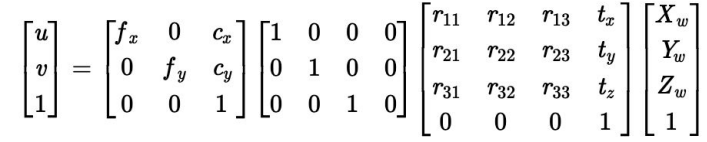



In [ ]:
from poseidon.torch import projection_all_point3D_to2D

points_2D = projection_all_point3D_to2D(points_3D, C, R, A)
print("2D points:\n", points_2D)

### Now we can apply the P3P algorithm 
- This algorithm returns a solution matrix where, for each batch, it provides four possible solutions.
- This algorithm takes as input the previously determined feature vectors and the 3D points.
- The solution is stored as a 4-layer matrix : for each layer the first column represents the translation vector, and the remaining three columns correspond to the rotation matrix.


In [ ]:
from poseidon.torch import P3P

solutions = P3P(points_3D, features_vectors)

print("P3P solutions:\n", solutions)

### Find the best solution 
- The P3P algorithm yields multiple possible camera poses.  
- To resolve this ambiguity, a fourth 2D-3D point correspondence is used to select the most accurate solution—specifically, the one with the lowest reprojection error.
- This algorithm returns the rotation and translation matrices that yield the smallest reprojection error, along with the reprojection error values for the four points.

In [ ]:
from poseidon.torch import find_best_solution_P3P_batch

R_solution, C_solution, estimation_error = find_best_solution_P3P_batch(
    solutions, points_2D, points_3D, A
)

print("\033[1m Estimated Rotation Matrix \033[0m (R_solution):\n ", R_solution)
print("\033[1m Original Rotation Matrix \033[0m  (R):\n", R, "\n")
print("\033[1m Estimated Camera Position \033[0m  (C_solution):\n", C_solution)
print("\033[1m Original Camera Position \033[0m (C):\n", C, "\n")
print("Estimation Error:\n", estimation_error)